# [MY CODE] Last word prediction dataset 준비

In [83]:
import torch
from datasets import load_dataset
from numpy.ma.extras import average
from torch.nn.functional import dropout
from torch.utils.data import DataLoader

ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
  max_len= 400
  texts, labels = [], []
  for row in batch:
    # 라벨을 감정이 아닌 각 텍스트의 뒷자리 단어(토큰) 2개로 변경
    tokenizer_output = tokenizer(row['text'], truncation=True, max_length=max_len)
    labels.append(tokenizer_output.input_ids[-2])
    texts.append(torch.LongTensor(tokenizer_output.input_ids[:-2]))

  # 패딩 처리(길이가 맞지 않는 경우를 위해)
  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

batch_size = 64
train_loader = DataLoader(
    ds['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

Using cache found in /Users/kimhongil/.cache/torch/hub/huggingface_pytorch-transformers_main


# [MY CODE] Shape와 입력/출력 확인(빈도 등)

In [84]:
ds['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [85]:
for batch in train_loader:
    inputs, labels = batch  # DataLoader에서 배치 추출
    print(f"입력 텍스트 (input_ids) shape: {inputs.shape}")
    print(f"출력 라벨 (labels) shape: {labels.shape}")
    break  # 첫 번째 배치만 확인

입력 텍스트 (input_ids) shape: torch.Size([64, 398])
출력 라벨 (labels) shape: torch.Size([64])


In [86]:
for batch in train_loader:
    inputs, labels = batch  # DataLoader에서 배치 추출

    # 첫 번째 샘플만 확인
    idx = 0
    first_input = inputs[idx]
    first_label = labels[idx]

    # 입력 텍스트 디코딩 (토큰 단위)
    decoded_tokens = tokenizer.convert_ids_to_tokens(first_input)
    decoded_text = tokenizer.decode(first_input)

    # 라벨 디코딩 (정답 토큰 ID를 텍스트로 변환)
    label_token = tokenizer.convert_ids_to_tokens([first_label])  # 라벨은 단일 토큰
    label_text = tokenizer.decode([first_label])  # 라벨을 문장으로 변환

    # 결과 출력
    print("입력 텍스트 (토큰):", decoded_tokens)
    print("입력 텍스트 (문장):", decoded_text)
    print("출력 라벨 (토큰):", label_token)
    print("출력 라벨 (문장):", label_text)

    break  # 첫 번째 배치만 확인

입력 텍스트 (토큰): ['[CLS]', 'i', 'am', 'not', 'so', 'much', 'like', 'love', 'sick', 'as', 'i', 'image', '.', 'finally', 'the', 'film', 'express', 'sexual', 'relationship', 'of', 'alex', ',', 'ki', '##k', ',', 'sand', '##u', 'their', 'triangle', 'love', 'were', 'full', 'of', 'intense', '##ness', ',', 'frustration', 'and', 'jealous', ',', 'at', 'last', ',', 'alex', 'wake', '##d', 'up', 'and', 'realized', 'that', 'they', 'would', 'not', 'have', 'result', 'and', 'future', '.', 'ending', 'up', 'was', 'sad', '.', '<', 'br', '/', '>', '<', 'br', '/', '>', 'the', 'director', 'tudor', 'gi', '##urg', '##iu', 'was', 'in', 'amc', 'theatre', 'on', 'sunday', '12', ':', '00pm', 'on', '08', '/', '10', '/', '06', ',', 'with', 'us', 'watched', 'the', 'movie', 'together', '.', 'after', 'the', 'movie', 'he', 'told', 'the', 'audiences', 'that', 'the', 'purpose', '##d', 'to', 'create', 'this', 'film', 'which', 'was', 'to', 'express', 'the', 'sexual', 'relationships', 'of', 'romanian', 'were', 'kind', 'of', 'com'

In [87]:
from collections import Counter

all_labels = []  # 모든 라벨을 저장할 리스트
label_counts = Counter(all_labels)
decoded_labels = tokenizer.convert_ids_to_tokens(list(label_counts.keys()))

# DataLoader에서 배치 순회
for batch in train_loader:
    inputs, labels = batch  # 라벨 추출
    all_labels.extend(labels.tolist())  # 리스트로 변환 후 확장

# 라벨의 유니크 값 확인
unique_labels = set(all_labels)
print("유니크 라벨 목록:", unique_labels)
print(f"총 유니크 라벨 개수: {len(unique_labels)}")


label_counts = Counter(all_labels)
top_10_labels = label_counts.most_common(10)  # 상위 10개 라벨
decoded_top_10 = tokenizer.convert_ids_to_tokens([item[0] for item in top_10_labels])

for word, (token_id, count) in zip(decoded_top_10, top_10_labels):
    print(f"라벨: {word} (토큰 ID: {token_id}) - 등장 횟수: {count}")

유니크 라벨 목록: {8195, 8201, 8212, 8226, 24623, 16437, 8246, 8257, 16451, 8266, 16465, 16467, 24665, 8282, 16481, 8290, 8292, 8307, 24703, 8321, 24714, 24759, 8378, 16571, 8385, 16596, 24795, 24808, 8428, 8429, 8434, 8440, 16636, 8450, 16643, 8472, 8484, 8485, 24871, 16681, 8489, 8490, 16701, 8516, 16709, 8518, 8527, 8529, 8562, 16755, 24947, 8568, 8569, 8572, 24965, 8586, 8589, 8596, 8605, 8607, 8631, 8632, 25020, 16833, 8674, 25066, 16880, 25093, 8713, 16914, 8739, 8740, 8754, 16948, 8785, 8794, 8795, 8797, 8814, 25219, 8836, 8847, 25248, 17075, 8884, 8889, 17083, 8909, 25314, 25325, 8943, 8948, 8954, 17153, 17156, 8973, 9000, 9004, 9009, 9019, 17211, 9027, 25423, 9056, 9061, 17274, 25469, 9092, 17289, 9102, 17298, 9110, 9117, 17312, 9120, 9122, 25508, 9129, 17324, 9143, 9145, 17339, 9148, 25539, 17363, 9179, 999, 1000, 1001, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 9202, 1010, 1012, 1013, 1014, 1011, 1015, 1016, 1017, 1018, 1019, 1020, 1022, 1023, 1024, 1021, 1026, 9219, 1028, 1029, 102

In [88]:
from torch import nn
import torch
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
max_len = 400


device = torch.device("mps")

## 주어진 코드

In [89]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

In [90]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

In [91]:

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    #preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

# [MY CODE] 마지막 토큰 반환

In [92]:
def get_last_valid_embeddings(x, input_ids, pad_token_id):
    """
    x: (B, S, D) shape (Transformer의 출력 혹은 embedding 결과)
    input_ids: (B, S) shape
    pad_token_id: 정수 (예: 0)

    return: (B, D) shape
    """
    # 1) PAD가 아닌 위치를 True로 표시
    mask = (input_ids != pad_token_id)    # (B, S)  ex) True/False

    # 2) 각 문장(배치)마다 유효 토큰 수
    lengths = mask.sum(dim=1)            # (B, )  ex) [3, 5, 2, ...]

    # 3) 마지막 유효 토큰 인덱스
    last_valid_indices = lengths - 1     # (B, )

    # 4) 인덱싱
    batch_indices = torch.arange(x.size(0))  # (B, ) => [0,1,2,...,B-1]
    last_embeddings = x[batch_indices, last_valid_indices, :]  # (B, D)

    return last_embeddings

In [97]:
def plot_acc(train_accuracies, test_accuracies, label1='train', label2='test'):
  x = np.arange(len(train_accuracies))

  plt.plot(x, train_accuracies, label=label1)
  plt.plot(x, test_accuracies, label=label2)
  plt.legend()
  plt.show()

# [MY CODE] Loss function 및 classifier output 변경

1. 이진분류 -> 다중 분류
 - loss_fn = nn.CrossEntropyLoss()
 - predict -> 로짓 출력 수정

2. 전체 토큰 수(Vocab Size), 이진 분류가 아니므로 ouput_size를 다양하게 시도
 - 전체 토큰 개수: 일반화에 좋음
 - 라벨 토큰 개수: 태스크가 분명한 경우

3. 어디 토큰을 사용할 것인가?
 - [CLS] : x[:, 0] -> 문장 전체 의미를 요약
 - 평균, 최대 등 등
 - 문장 끝
 - 버트는 cls가 좋다고 하지만... 우리가 요하는건 뒤에만 보면 충분하지않을까?!

4. 추가 전략: 중간 방식
 - 자주 등장하는 라벨(상위 N개)만 output_size로 설정

5. 최적화 기법
 - 드롭아웃
 - 가중치 공유 (난 입력과 출력 사이즈가 다르므로 안씀)

In [118]:
class TextEndPredictor(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, output_size, dropout_rate):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff


    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

    self.dropout_rate = dropout_rate
    self.dropout = nn.Dropout(self.dropout_rate)  # 드롭아웃 레이어 추가

    # 이진 분류가 아니므로 토큰 개수로 변경
    # 라벨 토큰 개수로 바꿔봄
    self.classification = nn.Linear(d_model, output_size)
    #self.classification.weight = self.embedding.weight  # 가중치 공유
    # 써보려했으나 쉐잎이 다름 난 ouput_Size가 라벨임 그러나 임베딩은 vocab

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    input_idx = x
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    for layer in self.layers:
        x = layer(x, mask)


    # 최종 선택
    #x = x[:, 0]
    x = get_last_valid_embeddings(x,  input_idx, pad_token_id=tokenizer.pad_token_id)

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    x = self.classification(x)

    return x

In [96]:
import time

# 라벨 토큰 개수로 바꿔봄
model = TextEndPredictor(len(tokenizer), 32, 2, 32, len(unique_labels), dropout_rate=0)

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

time_list = []
average_loss_list = []
train_accuracies = []
test_accuracies = []
perplexity_list = []

n_epochs = 50
start_epoch = 0


checkpoint_path = 'checkpoint_TextEndPredictor.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    average_loss_list = checkpoint['average_loss_list']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    perplexity_list = checkpoint['perplexity_list']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Loss: {average_loss_list[epoch]:.2f} |"
        f" Perplexity: {perplexity_list[epoch]:.2f} |"
        f" Train Acc: {train_accuracies[epoch]:.3f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")

for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()

        #preds = model(inputs)[..., 0] # 이진 분류에서 로짓 추출 (기존 손실 함수는 로짓을 원함)
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

    end_time = time.time()
    epoch_time = end_time - start_time  # 에포크 실행 시간 계산

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        time_list.append(epoch_time)
        average_loss_list.append(average_loss)
        perplexity = torch.exp(torch.tensor(average_loss))  # e^Loss로 퍼플렉서티 계산
        perplexity_list.append(perplexity)

    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'average_loss_list': average_loss_list,
        'perplexity_list':  perplexity_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, checkpoint_path)

    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Loss: {average_loss:.2f} |"
    f" Perplexity: {perplexity:.2f} |"
    f" Train Acc: {train_acc:.3f} |"
    f" Test Acc: {test_acc:.3f}")


새롭게 시작~
Epoch   1 | Time: 32.75 seconds | Loss: 2.15 | Perplexity: 8.63 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   2 | Time: 33.17 seconds | Loss: 1.72 | Perplexity: 5.56 | Train Acc: 0.573 | Test Acc: 0.578
Epoch   3 | Time: 34.56 seconds | Loss: 1.58 | Perplexity: 4.84 | Train Acc: 0.575 | Test Acc: 0.577
Epoch   4 | Time: 32.74 seconds | Loss: 1.51 | Perplexity: 4.54 | Train Acc: 0.581 | Test Acc: 0.582
Epoch   5 | Time: 33.68 seconds | Loss: 1.47 | Perplexity: 4.34 | Train Acc: 0.585 | Test Acc: 0.586
Epoch   6 | Time: 32.85 seconds | Loss: 1.44 | Perplexity: 4.21 | Train Acc: 0.589 | Test Acc: 0.588
Epoch   7 | Time: 32.97 seconds | Loss: 1.39 | Perplexity: 4.03 | Train Acc: 0.591 | Test Acc: 0.590
Epoch   8 | Time: 31.42 seconds | Loss: 1.37 | Perplexity: 3.92 | Train Acc: 0.592 | Test Acc: 0.590
Epoch   9 | Time: 30.82 seconds | Loss: 1.35 | Perplexity: 3.85 | Train Acc: 0.594 | Test Acc: 0.586
Epoch  10 | Time: 32.34 seconds | Loss: 1.33 | Perplexity: 3.78 | Train Acc: 0.594 

'\nEpoch   1 | Time: 33.34 seconds | Loss: 2.51 | Perplexity: 3.81 | Train Acc: 0.558 | Test Acc: 0.564\nEpoch   2 | Time: 33.30 seconds | Loss: 1.92 | Perplexity: 3.41 | Train Acc: 0.558 | Test Acc: 0.564\nEpoch   3 | Time: 33.82 seconds | Loss: 1.85 | Perplexity: 3.65 | Train Acc: 0.558 | Test Acc: 0.564\nEpoch   4 | Time: 33.72 seconds | Loss: 1.81 | Perplexity: 3.37 | Train Acc: 0.558 | Test Acc: 0.564\nEpoch   5 | Time: 32.41 seconds | Loss: 1.79 | Perplexity: 2.93 | Train Acc: 0.558 | Test Acc: 0.564\nEpoch   6 | Time: 33.16 seconds | Loss: 1.77 | Perplexity: 3.03 | Train Acc: 0.558 | Test Acc: 0.564\n'

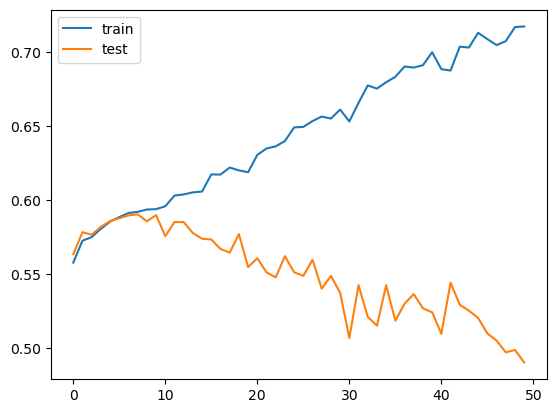

In [98]:
plot_acc(train_accuracies, test_accuracies)

# [MY CODE] 최적화 적용
 - cls로 다시 변경
 - 드롭아웃 (0.3)
 - weight_decay=1e-5
 - 가중치 공유

In [122]:
class TextEndPredictor2(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, output_size, dropout_rate):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff


    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])

    self.dropout_rate = dropout_rate
    self.dropout = nn.Dropout(self.dropout_rate)  # 드롭아웃 레이어 추가

    # 이진 분류가 아니므로 토큰 개수로 변경
    # 라벨 토큰 개수로 바꿔봄
    self.classification = nn.Linear(d_model, output_size)
    self.classification.weight = self.embedding.weight  # 가중치 공유
    # 써보려했으나 쉐잎이 다름 난 ouput_Size가 라벨임 그러나 임베딩은 vocab

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    input_idx = x
    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    for layer in self.layers:
        x = layer(x, mask)


    # 최종 선택
    x = x[:, 0]
    #x = get_last_valid_embeddings(x,  input_idx, pad_token_id=tokenizer.pad_token_id)

    if self.dropout_rate > 0:
        x = self.dropout(x) # 드롭아웃

    x = self.classification(x)

    return x

In [124]:
import time

# 라벨 토큰 개수로 바꿔봄
model = TextEndPredictor2(len(tokenizer), 32, 2, 32, len(tokenizer), dropout_rate=0.3)

lr = 0.001
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

time_list = []
average_loss_list = []
train_accuracies = []
test_accuracies = []
perplexity_list = []

n_epochs = 50
start_epoch = 0


checkpoint_path = 'checkpoint_TextEndPredictor2.pth'

try:
    checkpoint = torch.load(checkpoint_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']  # 이어서 시작할 에포크
    time_list = checkpoint['time_list']
    average_loss_list = checkpoint['average_loss_list']
    train_accuracies = checkpoint['train_accuracies']
    test_accuracies = checkpoint['test_accuracies']
    perplexity_list = checkpoint['perplexity_list']
    for epoch in range(0, start_epoch):
        print(f"Epoch {epoch+1:3d} |"
        f" Time: {time_list[epoch]:.2f} seconds |"
        f" Loss: {average_loss_list[epoch]:.2f} |"
        f" Perplexity: {perplexity_list[epoch]:.2f} |"
        f" Train Acc: {train_accuracies[epoch]:.3f} |"
        f" Test Acc: {test_accuracies[epoch]:.3f}")

    if start_epoch < n_epochs -1:
        print(f"이어서 시작~ {start_epoch + 1}.")
except FileNotFoundError:
    print("새롭게 시작~")

for epoch in range(start_epoch, n_epochs):
    start_time = time.time()  # 에포크 시작 시간 기록

    total_loss = 0.
    model.train()
    for data in train_loader:
        model.zero_grad()
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()

        #preds = model(inputs)[..., 0] # 이진 분류에서 로짓 추출 (기존 손실 함수는 로짓을 원함)
        preds = model(inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        average_loss = total_loss / len(train_loader)

    end_time = time.time()
    epoch_time = end_time - start_time  # 에포크 실행 시간 계산

    with torch.no_grad():
        model.eval()
        train_acc = accuracy(model, train_loader)
        test_acc = accuracy(model, test_loader)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        time_list.append(epoch_time)
        average_loss_list.append(average_loss)
        perplexity = torch.exp(torch.tensor(average_loss))  # e^Loss로 퍼플렉서티 계산
        perplexity_list.append(perplexity)

    # 체크포인트 저장
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'time_list': time_list,
        'average_loss_list': average_loss_list,
        'perplexity_list':  perplexity_list,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }, checkpoint_path)

    print(f"Epoch {epoch+1:3d} |"
    f" Time: {epoch_time:.2f} seconds |"
    f" Loss: {average_loss:.2f} |"
    f" Perplexity: {perplexity:.2f} |"
    f" Train Acc: {train_acc:.3f} |"
    f" Test Acc: {test_acc:.3f}")

새롭게 시작~
Epoch   1 | Time: 35.85 seconds | Loss: 5.78 | Perplexity: 323.56 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   2 | Time: 33.41 seconds | Loss: 4.12 | Perplexity: 61.36 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   3 | Time: 33.90 seconds | Loss: 3.70 | Perplexity: 40.50 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   4 | Time: 37.36 seconds | Loss: 3.53 | Perplexity: 34.11 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   5 | Time: 38.11 seconds | Loss: 3.43 | Perplexity: 31.02 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   6 | Time: 32.94 seconds | Loss: 3.36 | Perplexity: 28.81 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   7 | Time: 32.91 seconds | Loss: 3.31 | Perplexity: 27.37 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   8 | Time: 33.28 seconds | Loss: 3.26 | Perplexity: 25.97 | Train Acc: 0.558 | Test Acc: 0.564
Epoch   9 | Time: 33.17 seconds | Loss: 3.22 | Perplexity: 25.02 | Train Acc: 0.558 | Test Acc: 0.564
Epoch  10 | Time: 33.06 seconds | Loss: 3.19 | Perplexity: 24.18 | Train 

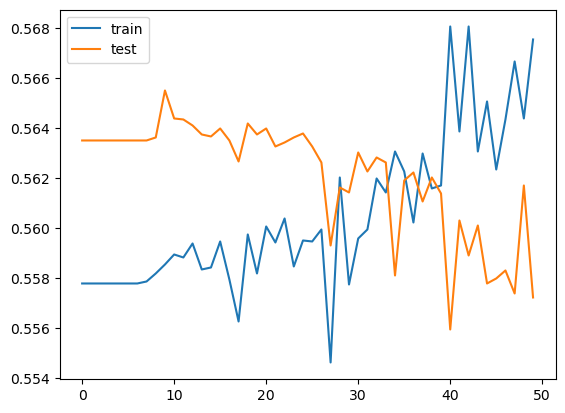

In [126]:
plot_acc(train_accuracies, test_accuracies)